In [1]:
import pandas as pd
import geopandas as gpd

# 读取交通事故数据
accident_data = pd.read_csv(
    'https://raw.githubusercontent.com/YULI61/QM_group_assessment/main/dft-road-casualty-statistics-collision-2023.csv',
    low_memory=False
)


# 读取车流量数据
traffic_data = pd.read_csv('https://github.com/YULI61/QM_group_assessment/raw/refs/heads/main/dft_aadf_region_id_6.csv')

# 读取行政区域边界数据（例如一个 Shapefile）
admin_boundaries = gpd.read_file('https://github.com/YULI61/QM_group_assessment/raw/refs/heads/main/LAD_Dec_2015_FCB_GB_2022_-1836983239597816196/LAD_Dec_2015_FCB_GB.shp')

In [2]:
from shapely.geometry import Point

# 将交通事故数据转换为 GeoDataFrame
accident_data['geometry'] = accident_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
accident_gdf = gpd.GeoDataFrame(accident_data, geometry='geometry', crs="EPSG:4326")

# 将车流量数据转换为 GeoDataFrame
traffic_data['geometry'] = traffic_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
traffic_gdf = gpd.GeoDataFrame(traffic_data, geometry='geometry', crs="EPSG:4326")

# 确保行政区数据的 CRS 与事故和车流量数据一致
admin_boundaries = admin_boundaries.to_crs(epsg=4326)

In [3]:
# 转27700
accident_gdf = accident_gdf.to_crs(epsg=27700)
traffic_gdf = traffic_gdf.to_crs(epsg=27700)
admin_boundaries = admin_boundaries.to_crs(epsg=27700)

print(accident_gdf.crs)

EPSG:27700


In [4]:
# 提取伦敦的数据（假设 'lad15cd' 为行政区编码字段）
london_admin_boundaries = admin_boundaries[admin_boundaries['lad15cd'].str.contains('^E09')]

In [5]:
# 只选择2023年的数据
traffic_2023_gdf = traffic_gdf[traffic_gdf['year'] == 2023]

# 查看提取后的数据u 
print(traffic_2023_gdf.head())

     count_point_id  year  region_id region_name  local_authority_id  \
23             6000  2023          6      London                  57   
47             6001  2023          6      London                  57   
71             6013  2023          6      London                  66   
95             6071  2023          6      London                  93   
119            6075  2023          6      London                  96   

    local_authority_name road_name road_type start_junction_road_name  \
23                Barnet        M1     Major                     A406   
47                Barnet        M1     Major                        2   
71            Hillingdon        M4     Major                        4   
95         Tower Hamlets       A12     Major                      A13   
119            Islington        A1     Major         A503 Camden Road   

                end_junction_road_name  ...   lgvs  hgvs_2_rigid_axle  \
23                             M1 spur  ...  11597     

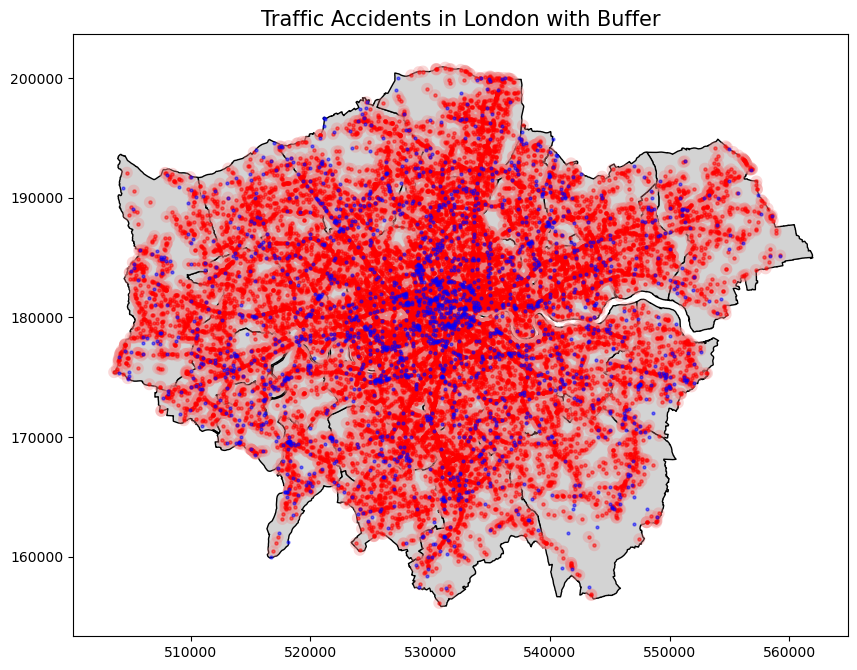

In [7]:
import matplotlib.pyplot as plt

# 使用空间连接将交通事故数据与伦敦行政区进行连接，获取位于伦敦的事故
london_accidents_gdf = gpd.sjoin(accident_gdf, london_admin_boundaries, how="inner", predicate='within')

# 为交通事故数据创建缓冲区，单位为米（假设 500 米）
london_accidents_gdf['buffer'] = london_accidents_gdf.geometry.buffer(500)

# 可视化
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制伦敦行政区边界（灰色）
london_admin_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')

# 绘制交通事故缓冲区（浅红色，透明度设置为0.3）
london_accidents_gdf['buffer'].plot(ax=ax, color='lightcoral', alpha=0.3)

# 绘制伦敦交通事故点（红色）
london_accidents_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# 绘制车流量检测
traffic_2023_gdf.plot(ax=ax, color='blue', marker='o', label="traffic Points", alpha=0.5, markersize=4)

# 添加标题
ax.set_title('Traffic Accidents in London with Buffer', fontsize=15)

# 显示图形
plt.show()

In [ ]:
#即使设置了缓冲区 还是会有交通事故没有对应的检测点
#用行政区车流量来对应

In [8]:
print(london_admin_boundaries.head())

       lad15cd               lad15nm lad15nmw  \
293  E09000001        City of London     None   
294  E09000002  Barking and Dagenham     None   
295  E09000003                Barnet     None   
296  E09000004                Bexley     None   
297  E09000005                 Brent     None   

                                 GlobalID  \
293  e1f49b92-326c-41a3-b695-e7bf86577f2f   
294  ad327cad-7cc8-470d-89a6-6a135f179ce2   
295  e2035a57-3430-44c2-bee4-24d296c62193   
296  b7aa58ca-6753-439d-acd3-04b214e2fecd   
297  ffc966a3-7d4f-4e17-bb64-89353153653e   

                                              geometry  
293  POLYGON ((532140.3 182191.9, 532141.5 182188.7...  
294  MULTIPOLYGON (((548881.8 190803, 548881.2 1907...  
295  POLYGON ((524579.9 198355.2, 524594.3 198321.4...  
296  MULTIPOLYGON (((547801.8 181521.8, 547927 1814...  
297  POLYGON ((520284.7 190241.4, 520319.4 190197.5...  


In [19]:
# 使用空间连接将每个事故点匹配到所属的行政区
# 在行政区中使用 'lad15nm' 列作为区域名称
london_accidents_gdf = gpd.sjoin(
    london_accidents_gdf, 
    london_admin_boundaries[['geometry', 'lad15nm']],  # 只保留必要的列
    how="left", 
    predicate='within',
    lsuffix='accident',  # 为左表的列添加后缀
    rsuffix='boundary'   # 为右表的列添加后缀
)

# 将 'lad15nm' 重命名为 'local_authority_name'
london_accidents_gdf = london_accidents_gdf.rename(columns={'lad15nm': 'local_authority_name'})

# 删除空间连接过程中生成的多余列
london_accidents_gdf = london_accidents_gdf.drop(columns=['index_boundary'])

# 查看结果，确认每个事故点是否得到了正确的行政区
print(london_accidents_gdf.head())

  accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  enhanced_severity_collision  \
0                  3                   1  ...                       

In [10]:
print(traffic_2023_gdf.columns)

Index(['count_point_id', 'year', 'region_id', 'region_name',
       'local_authority_id', 'local_authority_name', 'road_name', 'road_type',
       'start_junction_road_name', 'end_junction_road_name', 'easting',
       'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'estimation_method', 'estimation_method_detailed',
       'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles', 'geometry'],
      dtype='object')


In [11]:
# 提取 traffic_2023_gdf 中的 'local_authority_name' 和 'all_motor_vehicles'
traffic_data = traffic_2023_gdf[['local_authority_name', 'all_motor_vehicles']]

# 按照 'local_authority_name' 分组，并计算每个行政区的总车流量
traffic_summary = traffic_data.groupby('local_authority_name', as_index=False).sum()

# 重命名列名为更具语义的名称
traffic_summary = traffic_summary.rename(columns={
    'local_authority_name': 'Administrative Area',
    'all_motor_vehicles': 'Total Traffic Volume'
})

# 查看结果
print(traffic_summary.head())

    Administrative Area  Total Traffic Volume
0  Barking and Dagenham                778903
1                Barnet               2884424
2                Bexley               1444272
3                 Brent               1399297
4               Bromley                944088


In [21]:
# 确保列名一致
traffic_summary = traffic_summary.rename(columns={'Administrative Area': 'local_authority_name'})

# 合并数据，基于 'local_authority_name' 进行匹配
london_accidents_gdf = london_accidents_gdf.merge(
    traffic_summary,           # 需要合并的数据框
    on='local_authority_name', # 连接的列名
    how='left'                 # 使用左连接，保留所有事故点
)

# 查看合并后的列
print(london_accidents_gdf.columns)

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location',
       'enhanced_severity_collision', 'geometry', 'index_right', 'lad15cd',
       'lad15nm_accid

In [26]:
columns_to_extract = [
    'accident_index', 'accident_reference', 'longitude', 'latitude', 'police_force', 
    'day_of_week', 'road_type', 'speed_limit', 'junction_detail', 'junction_control',
    'light_conditions', 'weather_conditions', 'urban_or_rural_area', 
    'did_police_officer_attend_scene_of_accident', 'geometry', 'index_right', 
    'lad15cd', 'lad15nm_accident',  'GlobalID', 'buffer', 
    'local_authority_name', 'Total Traffic Volume_x'
]

# 从 london_accidents_gdf 中提取指定的列
Accidentgdf = london_accidents_gdf[columns_to_extract]

# 查看新的 DataFrame
print(Accidentgdf.head())

  accident_index accident_reference  longitude   latitude  police_force  \
0  2023010419171          010419171  -0.202878  51.418974             1   
1  2023010419183          010419183  -0.042464  51.671155             1   
2  2023010419189          010419189  -0.435789  51.487777             1   
3  2023010419191          010419191  -0.263972  51.597575             1   
4  2023010419192          010419192  -0.168976  51.477324             1   

   day_of_week  road_type  speed_limit  junction_detail  junction_control  \
0            1          2           20                9                 4   
1            1          6           30                3                 4   
2            1          1           30                1                 4   
3            1          6           30                3                 4   
4            1          6           30                8                 4   

   ...  urban_or_rural_area  did_police_officer_attend_scene_of_accident  \
0  ...    

In [31]:
# 映射 day_of_week 列
Accidentgdf.loc[:, 'day_type'] = Accidentgdf['day_of_week'].map(
    lambda x: 'workdays' if x in [1, 2, 3, 4, 5] else 'weekends'
)

# 按 'local_authority_name' 分组统计事故数量
accident_counts = Accidentgdf.groupby('local_authority_name').size()

# 将统计结果添加回原 DataFrame
Accidentgdf.loc[:, 'accident_count'] = Accidentgdf['local_authority_name'].map(accident_counts)# 映射 day_of_week 列
Accidentgdf.loc[:, 'day_type'] = Accidentgdf['day_of_week'].map(
    lambda x: 'workdays' if x in [1, 2, 3, 4, 5] else 'weekends'
)

# 按 'local_authority_name' 分组统计事故数量
accident_counts = Accidentgdf.groupby('local_authority_name').size()

# 将统计结果添加回原 DataFrame
Accidentgdf.loc[:, 'accident_count'] = Accidentgdf['local_authority_name'].map(accident_counts)

print(Accidentgdf.columns)

Index(['accident_index', 'accident_reference', 'longitude', 'latitude',
       'police_force', 'day_of_week', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'light_conditions',
       'weather_conditions', 'urban_or_rural_area',
       'did_police_officer_attend_scene_of_accident', 'geometry',
       'index_right', 'lad15cd', 'lad15nm_accident', 'GlobalID', 'buffer',
       'local_authority_name', 'Total Traffic Volume_x', 'day_type',
       'accident_count'],
      dtype='object')


Correlation with 'accident_count':
                                             accident_count
accident_count                                     1.000000
Total Traffic Volume_x                             0.400233
junction_detail                                    0.091725
junction_control                                   0.074222
did_police_officer_attend_scene_of_accident        0.071722
road_type                                          0.034580
weather_conditions                                 0.027465
light_conditions                                   0.015246
day_type                                          -0.000172
urban_or_rural_area                               -0.099576
speed_limit                                       -0.164430


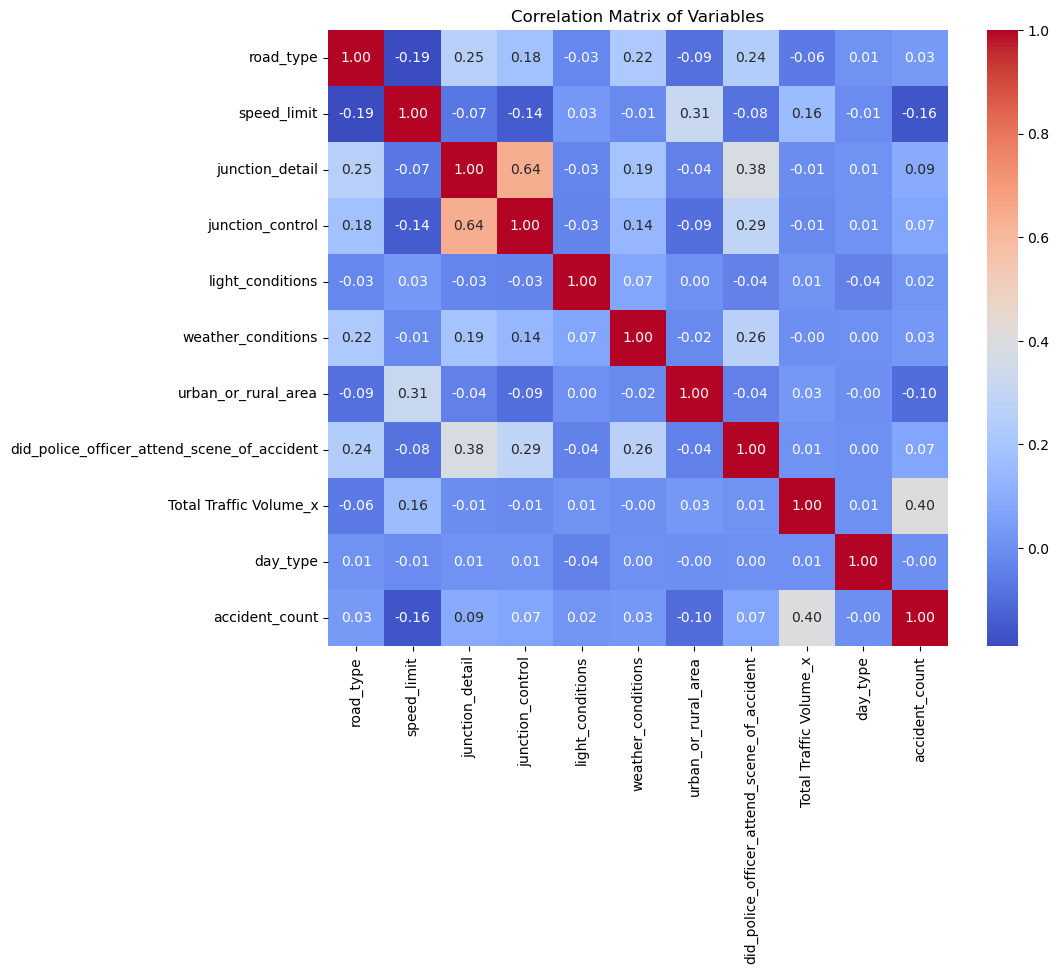

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 自变量和因变量
variables = [
    'road_type', 'speed_limit', 'junction_detail', 'junction_control', 
    'light_conditions', 'weather_conditions', 'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident', 'Total Traffic Volume_x', 'day_type'
]
dependent_var = 'accident_count'

# 提取相关列
data = Accidentgdf[variables + [dependent_var]].copy()

# 编码分类变量为数字（用 LabelEncoder）
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
for col in variables:  # 逐列检查是否为分类变量并编码
    if data[col].dtype == 'object':
        data[col] = label_enc.fit_transform(data[col])

# 计算相关矩阵
correlation_matrix = data.corr()

# 提取因变量的相关性
accident_corr = correlation_matrix[[dependent_var]].sort_values(by=dependent_var, ascending=False)

# 打印相关性
print("Correlation with 'accident_count':")
print(accident_corr)

# 可视化相关矩阵（全变量）
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title("Correlation Matrix of Variables")
plt.show()

In [34]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# 提取自变量
variables = [
    'road_type', 'speed_limit', 'junction_detail', 'junction_control', 
    'light_conditions', 'weather_conditions', 'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident', 'Total Traffic Volume_x', 'day_type'
]

# 对非数值型变量进行编码（如有）
from sklearn.preprocessing import LabelEncoder
encoded_data = Accidentgdf[variables].copy()

# 将分类变量编码为数字
label_enc = LabelEncoder()
for col in encoded_data.columns:
    if encoded_data[col].dtype == 'object':
        encoded_data[col] = label_enc.fit_transform(encoded_data[col])

# 计算 VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = encoded_data.columns
vif_data["VIF"] = [
    variance_inflation_factor(encoded_data.values, i) for i in range(encoded_data.shape[1])
]

# 查看 VIF 结果
print(vif_data)

                                      Variable        VIF
0                                    road_type   7.460293
1                                  speed_limit  13.392253
2                              junction_detail   2.205413
3                             junction_control   3.693932
4                             light_conditions   2.649828
5                           weather_conditions   1.918740
6                          urban_or_rural_area  23.536080
7  did_police_officer_attend_scene_of_accident   5.546813
8                       Total Traffic Volume_x   9.311410
9                                     day_type   3.265659


In [38]:
Accidentgdf.to_csv('Accidentgdf.csv', index=True)  # 不导出行索引

In [59]:
london_accidents_gdf.drop(columns="geometry").to_csv("london_accidents.csv", index=True)

                                               accident_count
accident_count                                       1.000000
Total Traffic Volume_x                               0.400233
junction_detail_99                                   0.086608
junction_control_9                                   0.081098
did_police_officer_attend_scene_of_accident_3        0.072045
junction_control_2                                   0.066574
road_type_9                                          0.054948
road_type_2                                          0.053125
junction_detail_6                                    0.045521
weather_conditions_9                                 0.039490
junction_control_3                                   0.024602
junction_detail_7                                    0.015614
light_conditions_7                                   0.015368
light_conditions_4                                   0.013099
junction_detail_9                                    0.012725
junction

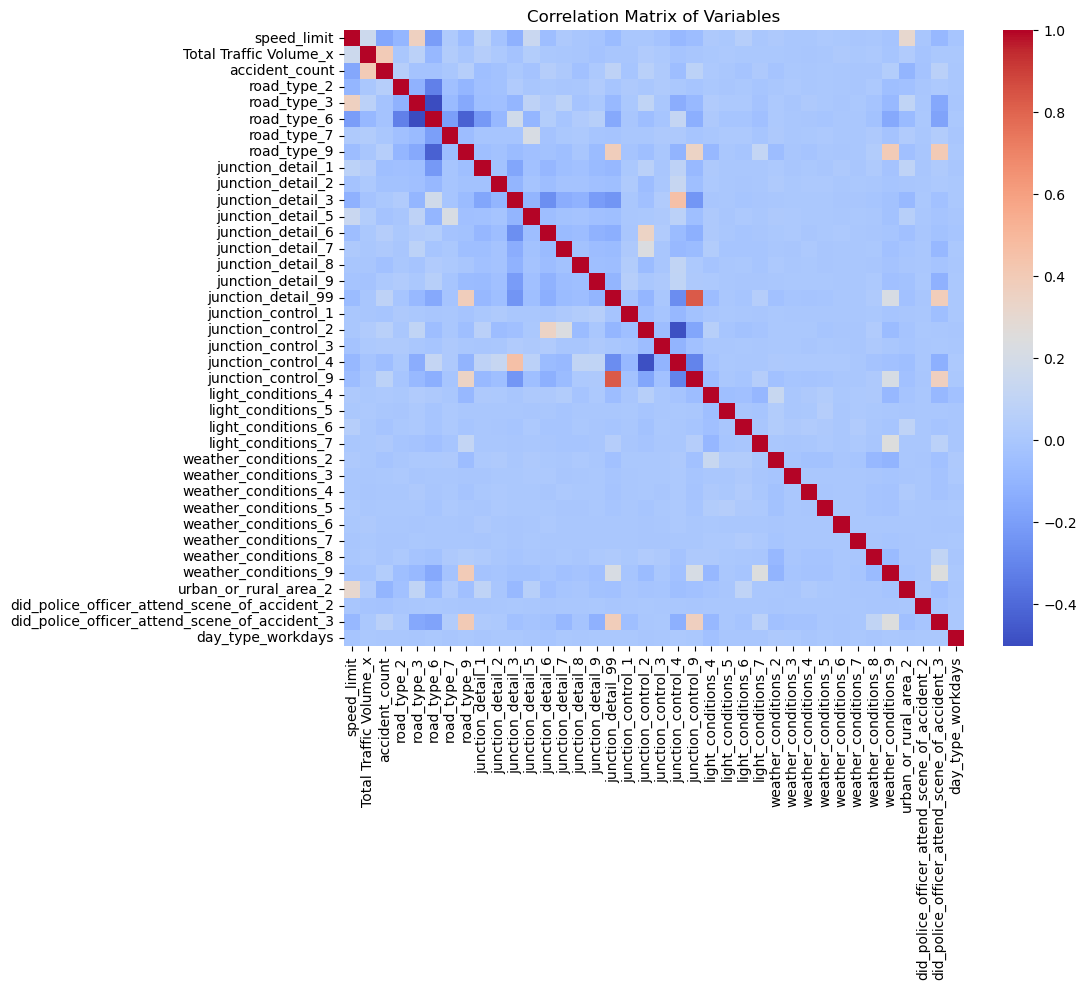

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 自变量和因变量
variables = [
    'road_type', 'speed_limit', 'junction_detail', 'junction_control', 
    'light_conditions', 'weather_conditions', 'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident', 'Total Traffic Volume_x', 'day_type'
]
dependent_var = 'accident_count'

# 确保只选取需要的列
data = Accidentgdf[variables + [dependent_var]].copy()

# 对分类变量进行独热编码
categorical_vars = ['road_type', 'junction_detail', 'junction_control', 
                    'light_conditions', 'weather_conditions', 'urban_or_rural_area', 
                    'did_police_officer_attend_scene_of_accident', 'day_type']
data_encoded = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

# 计算相关矩阵
correlation_matrix = data_encoded.corr()

# 只选因变量相关部分
accident_corr = correlation_matrix[[dependent_var]].sort_values(by=dependent_var, ascending=False)

# 打印相关性矩阵
print(accident_corr)

# 可视化相关矩阵（可选）
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix of Variables")
plt.show()

In [55]:
print(encoded_df.columns)

Index(['accident_index', 'accident_reference', 'longitude', 'latitude',
       'police_force', 'day_of_week', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'light_conditions',
       'weather_conditions', 'urban_or_rural_area',
       'did_police_officer_attend_scene_of_accident', 'geometry',
       'index_right', 'lad15cd', 'lad15nm_accident', 'GlobalID', 'buffer',
       'local_authority_name', 'Total Traffic Volume_x', 'accident_count',
       'day_type_workdays'],
      dtype='object')


Intercept: 687.709451378439
Coefficients: [-7.51627957e-01 -6.80045336e+00  6.42155636e-01 -8.22711067e-01
  3.03754157e+00  4.66301812e-01 -6.07518350e+01  5.83334231e+00
  2.24663696e-04 -2.53555323e+00]


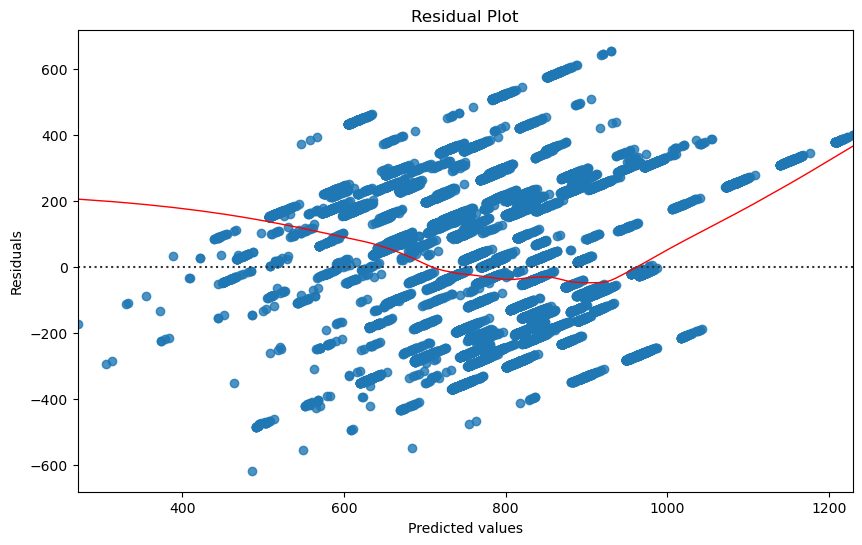

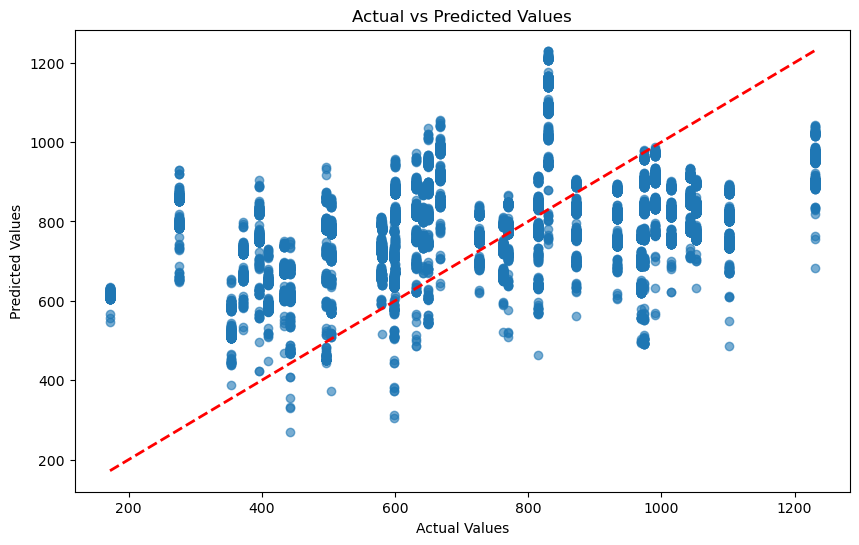

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 自变量（独热编码后的分类变量和其他变量）
X = encoded_df[['road_type', 'speed_limit', 'junction_detail', 'junction_control', 
    'light_conditions', 'weather_conditions', 'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident', 'Total Traffic Volume_x', 'day_type_workdays']]
y = encoded_df['accident_count']

# 拟合回归模型
model = LinearRegression().fit(X, y)

# 输出回归方程系数
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# 预测值
y_pred = model.predict(X)

# 绘制残差图
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=y_pred - y, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', lw=2, ls='--')  # 45度线
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Random Forest Model Accuracy: 0.884340859431901


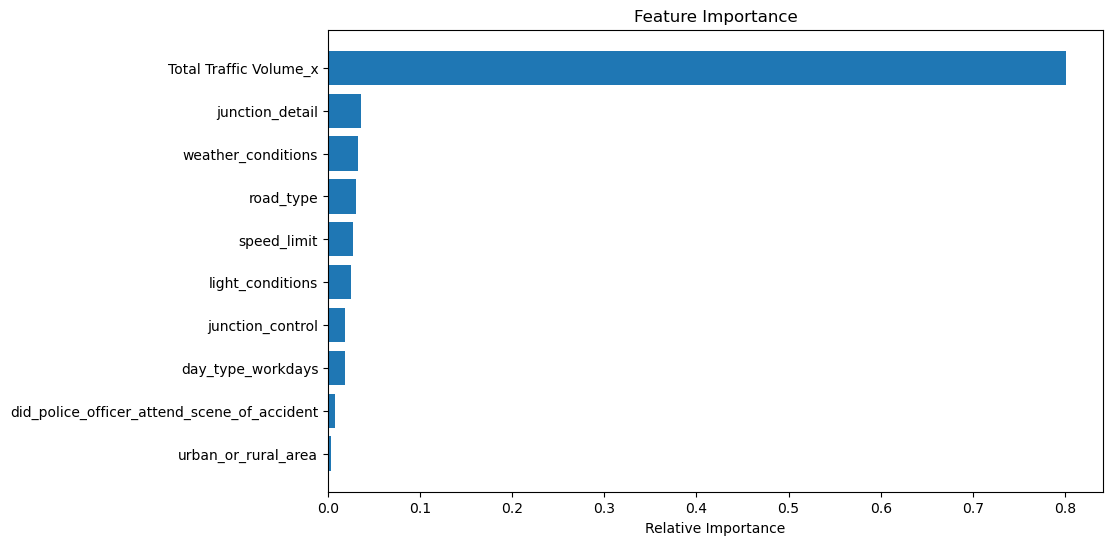

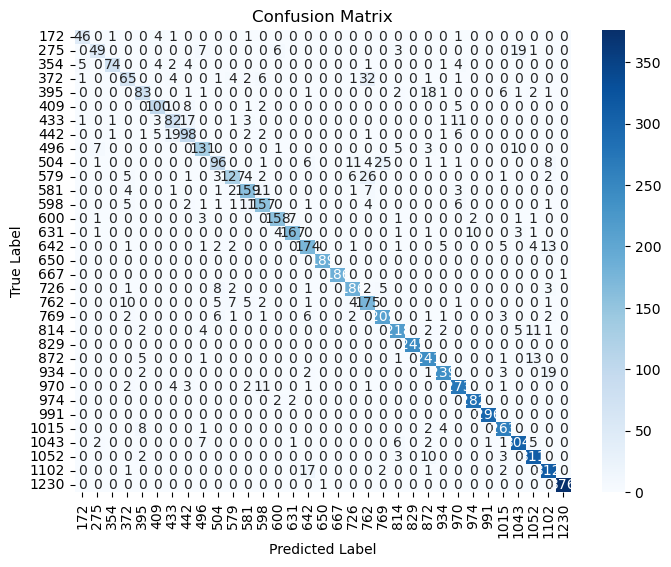

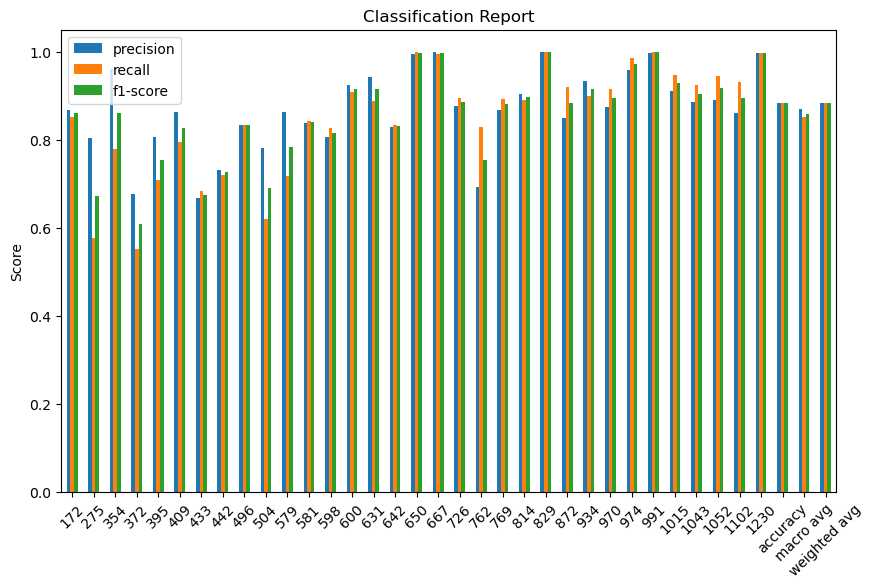

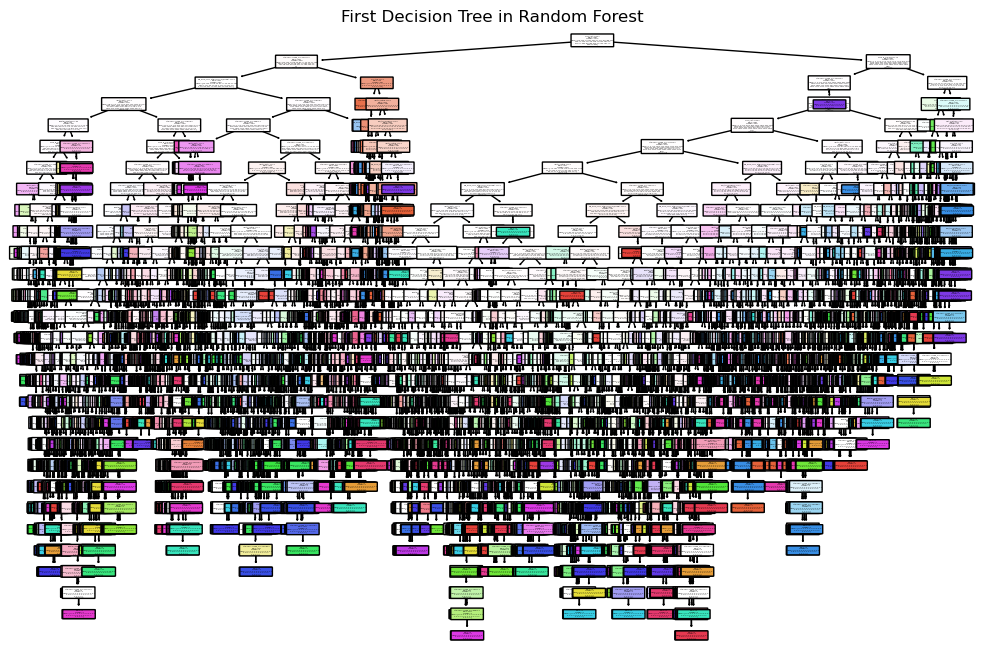

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 将自变量进行独热编码
X = pd.get_dummies(Accidentgdf[['road_type', 'speed_limit', 'junction_detail', 
                                 'junction_control', 'light_conditions', 
                                 'weather_conditions', 'urban_or_rural_area',
                                 'did_police_officer_attend_scene_of_accident',
                                 'Total Traffic Volume_x', 'day_type']], drop_first=True)

# 因变量
y = Accidentgdf['accident_count']  # 假设是一个分类变量

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义并训练随机森林模型
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# 预测和评估
y_pred = rf_clf.predict(X_test)

# 计算模型准确率
print(f'Random Forest Model Accuracy: {rf_clf.score(X_test, y_test)}')

# ---- 1. 特征重要性可视化 ----
# 获取特征重要性
feature_importances = rf_clf.feature_importances_

# 获取特征名称
features = X.columns

# 按照重要性排序
indices = feature_importances.argsort()

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), features[indices])
plt.xlabel("Relative Importance")
plt.show()

# ---- 2. 混淆矩阵热图 ----
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ---- 3. 分类报告可视化 ----
# 获取分类报告
report = classification_report(y_test, y_pred, output_dict=True)

# 转换为DataFrame
report_df = pd.DataFrame(report).transpose()

# 可视化精确度、召回率和F1分数
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# ---- 4. 绘制第一棵决策树 ----
from sklearn.tree import plot_tree

# 绘制第一棵树
plt.figure(figsize=(12, 8))
plot_tree(rf_clf.estimators_[0], filled=True, feature_names=X.columns, class_names=np.unique(y).astype(str), rounded=True)
plt.title("First Decision Tree in Random Forest")
plt.show()
